## Assemble final labels

Here, we'll gather all of the cell barcode labels generated for the major classes of PBMCs and generate a single complete set of annotations. We can then join these to the original, full PBMC dataset to generate a final object with all cell type annotations

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file, backed = 'r')
    return adata

In [3]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read barcode annotations

In [4]:
anno_uuids = [
    '6897e950-2719-4575-87d0-1d2307d5db63', # B cells
    'eff741c2-b0fe-4dff-9914-ff5dc89ee95e', # Myeloid cells
    'b57066f8-c0d5-4bfb-aa9b-79c743aa5886', # NK cells
    '09f10d41-3170-4317-ba84-650268fcfcd2', # Other cells
    '75cb6602-0179-4128-9171-83c269a2b340' # T cells
]

In [5]:
anno_list = []
for uuid in anno_uuids:
    anno = read_parquet_uuid(uuid)
    anno_list.append(anno)

downloading fileID: 6897e950-2719-4575-87d0-1d2307d5db63
Files have been successfully downloaded!


In [6]:
anno = pd.concat(anno_list)

In [7]:
anno.shape

(1952128, 4)

## Read original clustered data

In [8]:
h5ad_uuid = '9db48bed-cd91-49ae-abd2-447ae478ca96'

In [9]:
adata = read_adata_uuid(h5ad_uuid)

In [10]:
adata.shape

(1952128, 1236)

## Add annotations to dataset

In [11]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = False)

In [12]:
adata.obs = obs

## Preview annotations on UMAP projection

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


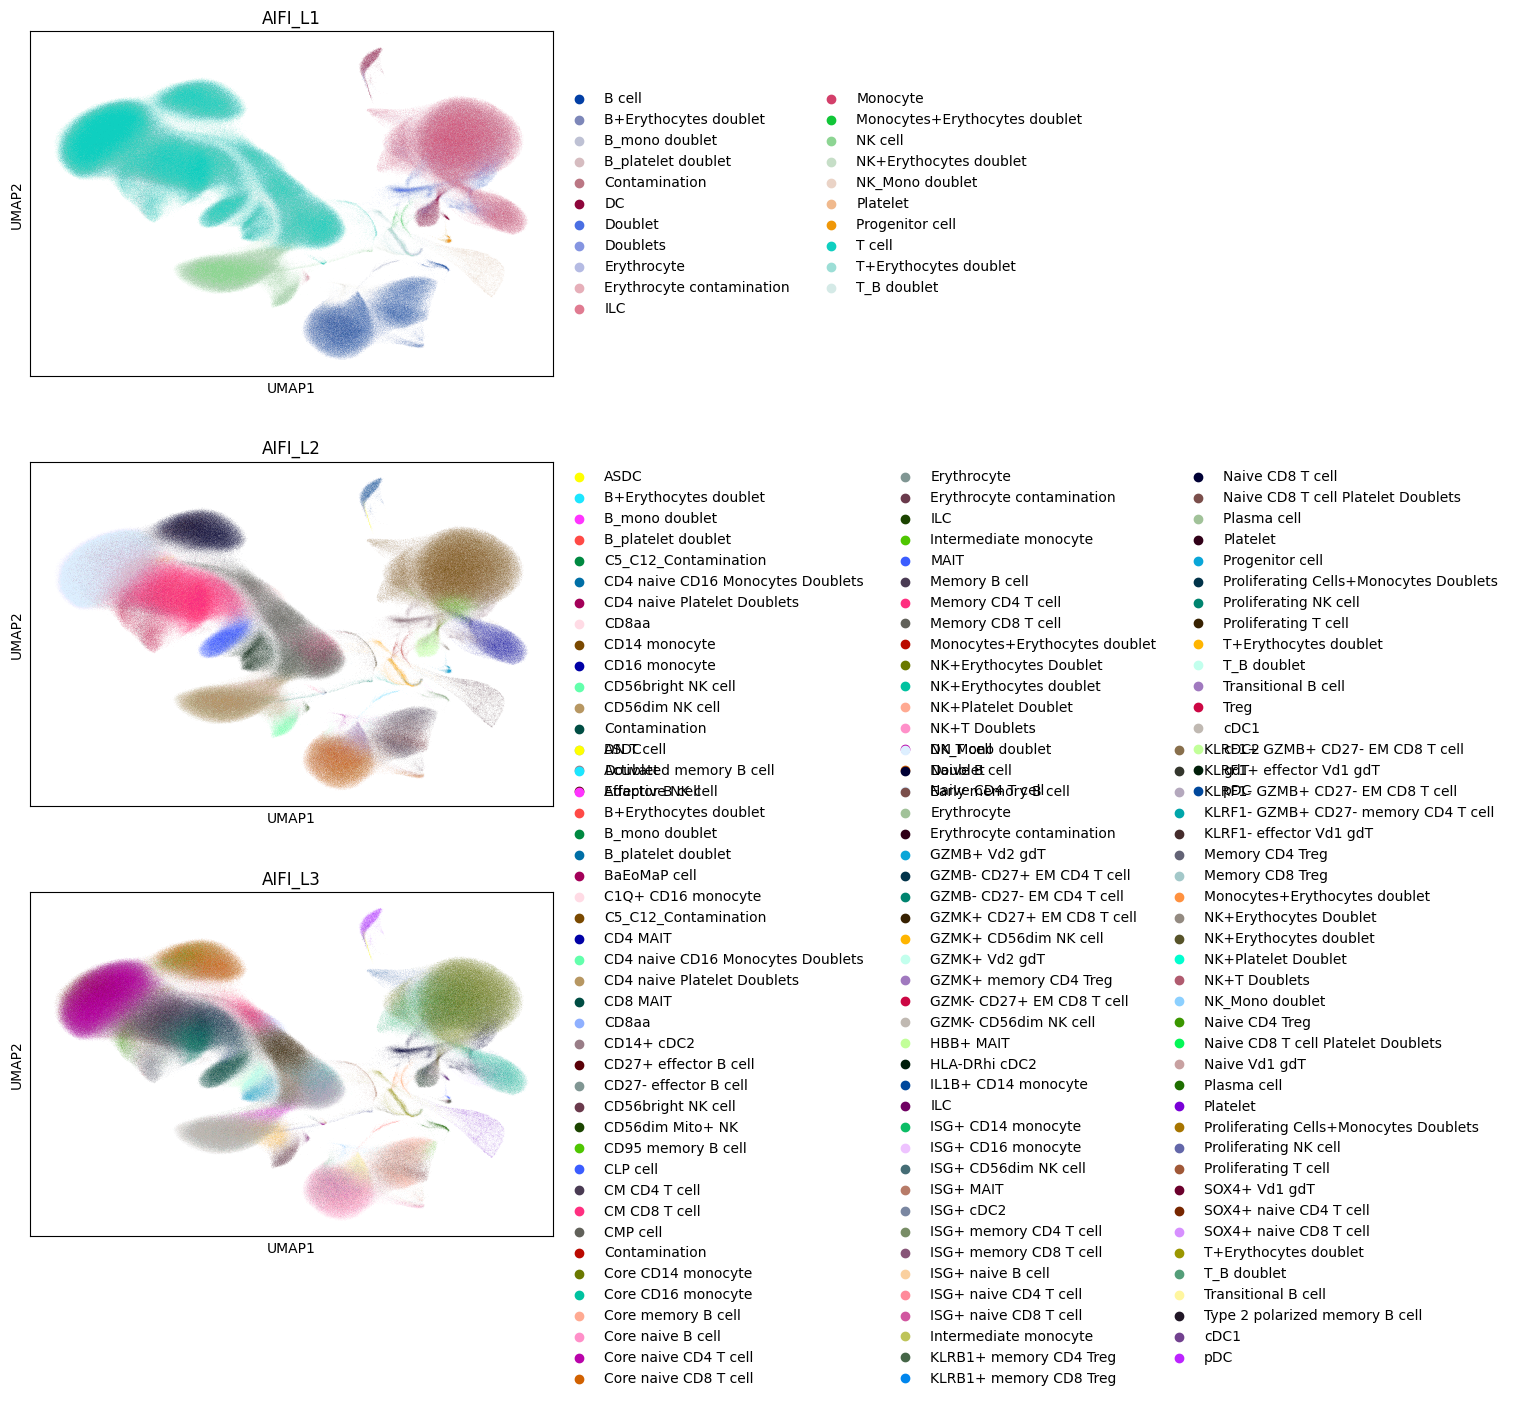

In [13]:
sc.pl.umap(
    adata,
    color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'],
    ncols = 1
)

## Output final annotations

In [14]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [15]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [16]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,AIFI_L1,AIFI_L2,AIFI_L3,umap_1,umap_2
0,cf71f47048b611ea8957bafe6d70929e,B001,weathered_pernicious_polliwog,cf71f47048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1081,115,9307,...,79.628331,115,4.753590,4.032258,13,T cell,MAIT,CD8 MAIT,0.069207,6.428511
1,cf71f54248b611ea8957bafe6d70929e,B001,untidy_emulsive_hamadryad,cf71f54248b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1923,178,22729,...,76.718846,178,5.187386,2.731737,2,T cell,Naive CD4 T cell,Core naive CD4 T cell,-6.025837,10.903475
2,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,78.295025,204,5.323010,5.935409,3,Monocyte,CD14 monocyte,Core CD14 monocyte,13.830215,9.230867
3,cf71fb7848b611ea8957bafe6d70929e,B001,long_weakminded_roebuck,cf71fb7848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1118,77,12990,...,83.378160,77,4.356709,2.071006,1,T cell,Memory CD4 T cell,CM CD4 T cell,-2.623835,10.297518
4,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,69.089532,363,5.897154,6.871096,9,Monocyte,CD14 monocyte,Core CD14 monocyte,12.289608,13.853219


In [17]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [18]:
obs_out_csv = '{p}/ref_pbmc_labeled_meta_umap_{d}.csv'.format(p = out_dir, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [19]:
obs_out_parquet = '{p}/ref_pbmc_labeled_meta_umap_{d}.parquet'.format(p = out_dir, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [20]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [21]:
label_out_csv = '{p}/ref_pbmc_barcode_labels_{d}.csv'.format(p = out_dir, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [22]:
label_out_parquet = '{p}/ref_pbmc_barcode_labels_{d}.parquet'.format(p = out_dir, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Output labeled AnnData

In [23]:
out_h5ad = '{p}/ref_pbmc_labeled_{d}.h5ad'.format(p = out_dir, d = date.today())
adata.write_h5ad(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [24]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Labeled 10x 3-prime PBMC Reference {d}'.format(d = date.today())

In [25]:
in_files = [h5ad_uuid] + anno_uuids

In [26]:
in_files

['9db48bed-cd91-49ae-abd2-447ae478ca96',
 '6897e950-2719-4575-87d0-1d2307d5db63',
 'eff741c2-b0fe-4dff-9914-ff5dc89ee95e',
 'b57066f8-c0d5-4bfb-aa9b-79c743aa5886',
 '09f10d41-3170-4317-ba84-650268fcfcd2',
 '75cb6602-0179-4128-9171-83c269a2b340']

In [27]:
out_files = [out_h5ad,
             obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [28]:
out_files

['output/ref_pbmc_labeled_2024-03-09.h5ad',
 'output/ref_pbmc_labeled_meta_umap_2024-03-09.csv',
 'output/ref_pbmc_labeled_meta_umap_2024-03-09.parquet',
 'output/ref_pbmc_barcode_labels_2024-03-09.csv',
 'output/ref_pbmc_barcode_labels_2024-03-09.parquet']

In [29]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_pbmc_labeled_2024-03-09.h5ad
output/ref_pbmc_labeled_meta_umap_2024-03-09.csv
output/ref_pbmc_labeled_meta_umap_2024-03-09.parquet
output/ref_pbmc_barcode_labels_2024-03-09.csv
output/ref_pbmc_barcode_labels_2024-03-09.parquet
you are trying to upload file_ids... ['output/ref_pbmc_labeled_2024-03-09.h5ad', 'output/ref_pbmc_labeled_meta_umap_2024-03-09.csv', 'output/ref_pbmc_labeled_meta_umap_2024-03-09.parquet', 'output/ref_pbmc_barcode_labels_2024-03-09.csv', 'output/ref_pbmc_barcode_labels_2024-03-09.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': '3db6a8db-b7e2-4d17-b5a9-608bab76bc2c',
 'files': ['output/ref_pbmc_labeled_2024-03-09.h5ad',
  'output/ref_pbmc_labeled_meta_umap_2024-03-09.csv',
  'output/ref_pbmc_labeled_meta_umap_2024-03-09.parquet',
  'output/ref_pbmc_barcode_labels_2024-03-09.csv',
  'output/ref_pbmc_barcode_labels_2024-03-09.parquet']}

In [30]:
import session_info
session_info.show()